In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from sbatch_pred.queuetime_prediction.model_training import get_model_data, get_input_features, partition_params
from sbatch_pred.queuetime_prediction.uncertainty_analysis import get_partition_results, get_results_df

from scipy.stats import iqr

from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

In [2]:
# Choose knowledge depth: cluster, partition, node, or combined
knowledge_depth='combined'

# Choose wallclock knowledge: user, pred, or perfect
wallclock_knowledge='pred'

model_data_df = get_model_data(knowledge_depth, wallclock_knowledge)

Loaded model data at path ../../data/model_data/model_data_partition_pred.parquet
Loaded model data at path ../../data/model_data/model_data_node_pred.parquet
Finished combinining partition- and node-level data


In [3]:
# Train Window: The number of days of data to use to train the model
#               ...Training data is collected from [split time - train window, split time)
train_window = 120

# Test Window: The number of days of data to use to test the model
#               ...Testing data is collected from [split time, split time + test_window)
test_window = 1

# Start Date: The initial split time (starts at 00:00am)
start_date = '2023-06-01'

# n_days: The number of days to test/number of split times (recommended 100-200 days)
n_days = 200

# Target: The target feature. Can use 'queue_wait' or 'queue_wait_log' (log scaled) for regression
target = 'queue_wait_log'

# Model Type: Use only regression for this analysis
model_type = 'xgb_reg'

# Get the input features, depending on the knowledge depth being used
features = get_input_features(knowledge_depth)

# Sensitivity Analysis

Though this setup looks very similar to the regular model training/testing process, they are ctually performing sensitivity analysis on the regression models.

More specifically, the models are trained exactly as before, but the testing process is different.

For each partition:
 - For each split time
    - A model is trained
    - For each job in the test set:
        - A queue time prediction is made as normal
        - **(Here is where it starts to be different)** Each feature value ($f$) of the input feature vector is perturbed based on a uniform distribution with a certain noise factor $N$ to get a perturbed value $f_p$ according to the following:
        - $f_p \sim U((1-N)f, ~(1+N)f))$
        - The trained model is used to get a prediction (queue wait pred) for this perturbed input feaature vector
        - The idea here is to get a prediction for a job in the same neighborhood of the original job, so the noise factor should be relatively small. We chose 0.1.
        - This perturbation-prediction process is repeated 100 times, which results in 100 predictions for queue wait.
        - The distribution of these 100 predictions is measured with four different scale-invariant *Relative Dispersion Indices (RDI)*:
            - Coefficient of Variation:
              
              $CV =\frac{\mu}{\sigma}$
            - Quartile Coefficient of Dispersion:
              
              $QCD = \frac{Q_3-Q_1}{Q_3+Q_1}$
            - Interquartile Range divided by the Median:
              
              $\frac{IQR}{median} = \frac{Q_3-Q_1}{\text{Med}(X)}$
            - Median Absolute Dispersion divided by the Median:
              
              $\frac{MAD}{median} = \frac{\text{Med}(|X_i - \text{Med}(X)|}{\text{Med}(X)}$
        - The four RDIs are then saved for each job - effectively providing four different metrics for the distribution of the wait time predictions resulting from the 100 perturbed input feature vectors for that job.
        - These RDIs serve as a measure for the sensitivity of the model in the neighborhood of the job, with higher RDI pointing to higher model sensitivity.

In [4]:
noise_magnitude = 0.1
partition_results = {}
params = {}

print(f'Getting results for partition: ', end='')
for partition in model_data_df.partition.unique():
    if partition == 'off3':
        continue # No node-level information for off3 partition
    print(f'{partition}', end=', ')
    partition_results[partition] = get_partition_results(model_data_df, train_window, test_window, start_date, 
                          features, target, partition, n_days=n_days, noise_magnitude=noise_magnitude, verbose=False)
results_df = get_results_df(partition_results, noise_magnitude=noise_magnitude)

Getting results for partition: standard, short-stdby, gpu, debug, short, bigmem, off2, long-stdby, long, standard-stdby, off1, debug-stdby, bigscratch, 

/Users/kmenear/Projects/sbatch_pred/environment/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:39:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397638960/work/src/objective/regression_obj.cu:743: Sum of weights is close to 0.0, skipping base score estimation.
  warnings.warn(smsg, UserWarning)
/Users/kmenear/Projects/sbatch_pred/environment/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:39:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397638960/work/src/common/error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)
/Users/kmenear/Projects/sbatch_pred/environment/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:39:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397638960/work/src/objective/regression_obj.cu:743: Sum of weights is close to 0.0, skipping base score estimation.
  warnings.warn(smsg, UserWarning)
/Users/kmenear/Projects/sbatch_pred/envir

off1-stdby, gpul, gpu-stdby, bigmem-stdby, 

In [5]:
results_df.to_parquet(f'../../data/results/perturbed_results_nm_{noise_magnitude}.parquet')

## Analyze results

### Fixed Factor Analysis

For this analysis, we set arbitrary upper and lower bounds based on some factor ($F$). To get the upper bound ($UB$), we multiply the predicted runtime ($r_p$) (from the unperturbed job feature vector) by the factor. To get the lower bound ($LB$), we divide the predicted runtime by the factor.

$UB = r_p*F$

$LB = \frac{r_p}{F}$

We then bin the jobs based on their RDI (we use $\frac{MAD}{median}$). For each bin, we determine the proportion of jobs for which the actual runtime $r_a$ is within the bounds. This proportion is reported as the $\text{Accuracy}$ for that bin.

In [6]:
factor = 10

results_df['lower_pred_artificial_bound'] = results_df['queue_wait_pred'] / factor
results_df['upper_pred_artificial_bound'] = results_df['queue_wait_pred'] * factor
results_df['artificial_accuracy'] = results_df['queue_wait'].between(results_df['lower_pred_artificial_bound'],
                                                                     results_df['upper_pred_artificial_bound'])

In [21]:
def plot_accuracy_vs_bins(df, plot_curves=False):
    partition = str(df.partition.unique().tolist()[0])
    if len(df) < 25000: 
        n_bins = 60
    else:
        n_bins = 180

    df = df[~df.cv.isna() & ~df.iqr_med.isna() & ~df.mad_med.isna() & ~df.qcd.isna()].copy()
    if len(df) < 1000:
        return

    print('\n\n')
    print('='*100)
    print(partition.center(100))
    print('='*100)
    
    df['cv_bins'] = pd.cut(np.log(df['cv']), bins=n_bins)
    df['iqr_med_bins'] = pd.cut(np.log(df['iqr_med']), bins=n_bins)
    df['mad_med_bins'] = pd.cut(df['mad_med'], bins=n_bins)
    df['qcd_bins'] = pd.cut(df['qcd'], bins=n_bins)

    cv_grouped = df.groupby('cv_bins')['artificial_accuracy'].mean()
    cv_counts =  df.groupby('cv_bins').size()
    iqr_med_grouped = df.groupby('iqr_med_bins')['artificial_accuracy'].mean()
    iqr_med_counts = df.groupby('iqr_med_bins').size()
    mad_med_grouped = df.groupby('mad_med_bins')['artificial_accuracy'].mean()
    mad_med_counts = df.groupby('mad_med_bins').size()
    qcd_grouped = df.groupby('qcd_bins')['artificial_accuracy'].mean()
    qcd_counts = df.groupby('qcd_bins').size()

    cv_grouped = cv_grouped[cv_counts > 20]
    cv_counts = cv_counts[cv_counts > 20]
    iqr_med_grouped = iqr_med_grouped[iqr_med_counts > 20]
    iqr_med_counts = iqr_med_counts[iqr_med_counts > 20]
    mad_med_grouped = mad_med_grouped[mad_med_counts > 20]
    mad_med_counts = mad_med_counts[mad_med_counts > 20]
    qcd_grouped = qcd_grouped[qcd_counts > 20]
    qcd_counts = qcd_counts[qcd_counts > 20]

    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    cv_mids = [bin.mid for bin in cv_grouped.index]
    scatter_cv = ax[0][0].scatter(np.exp(cv_mids), cv_grouped.values, c=cv_counts)
    ax[0][0].set_xscale('log')
    ax[0][0].set_xlabel('Binned CV')
    ax[0][0].set_ylabel('Mean Accuracy')
    ax[0][0].set_title(f'Mean Accuracy vs. Binned CV: {partition}')
    plt.colorbar(scatter_cv, ax=ax[0][0], label='# of Jobs in Bin')

    iqr_med_mids = [bin.mid for bin in iqr_med_grouped.index]
    scatter_iqr_med = ax[0][1].scatter(np.exp(iqr_med_mids), iqr_med_grouped.values, c=iqr_med_counts)
    ax[0][1].set_xscale('log')
    ax[0][1].set_xlabel('Binned IQR/Median')
    ax[0][1].set_ylabel('Mean Accuracy')
    ax[0][1].set_title(f'Mean Accuracy vs. Binned IQR/Median: {partition}')
    plt.colorbar(scatter_iqr_med, ax=ax[0][1], label='# of Jobs in Bin')

    mad_med_mids = [bin.mid for bin in mad_med_grouped.index]
    scatter_mad_med = ax[1][0].scatter(mad_med_mids, mad_med_grouped.values, c=mad_med_counts)
    #ax[1][0].set_xscale('log')
    ax[1][0].set_xlabel('Binned MAD/Median')
    ax[1][0].set_ylabel('Mean Accuracy')
    ax[1][0].set_title(f'Mean Accuracy vs. Binned MAD/Median: {partition}')
    plt.colorbar(scatter_mad_med, ax=ax[1][0], label='# of Jobs in Bin')

    qcd_mids = [bin.mid for bin in qcd_grouped.index]
    scatter_qcd = ax[1][1].scatter(qcd_mids, qcd_grouped.values, c=qcd_counts)
    #ax[1][1].set_xscale('log')
    ax[1][1].set_xlabel('Binned QCD')
    ax[1][1].set_ylabel('Mean Accuracy')
    ax[1][1].set_title(f'Mean Accuracy vs. QCD: {partition}')
    plt.colorbar(scatter_qcd, ax=ax[1][1], label='# of Jobs in Bin')

    if plot_curves:
        coefficients = np.polyfit(np.exp(cv_mids), cv_grouped.values, 10)
        polynomial = np.poly1d(coefficients)
        x_curve = np.linspace(min(np.exp(cv_mids)), max(np.exp(cv_mids)), 200)
        y_curve = polynomial(x_curve)
        ax[0][0].plot(x_curve, y_curve)
        
        coefficients = np.polyfit(np.exp(iqr_med_mids), iqr_med_grouped.values, 10)
        polynomial = np.poly1d(coefficients)
        x_curve = np.linspace(min(np.exp(iqr_med_mids)), max(np.exp(iqr_med_mids)), 200)
        y_curve = polynomial(x_curve)
        ax[0][1].plot(x_curve, y_curve)
        
        coefficients = np.polyfit(mad_med_mids, mad_med_grouped.values, 10)
        polynomial = np.poly1d(coefficients)
        x_curve = np.linspace(min(mad_med_mids), max(mad_med_mids), 200)
        y_curve = polynomial(x_curve)
        ax[1][0].plot(x_curve, y_curve)
        
        coefficients = np.polyfit(qcd_mids, qcd_grouped.values, 10)
        polynomial = np.poly1d(coefficients)
        x_curve = np.linspace(min(qcd_mids), max(qcd_mids), 200)
        y_curve = polynomial(x_curve)
        ax[1][1].plot(x_curve, y_curve)

    plt.tight_layout()
    plt.show()




                                              standard                                              


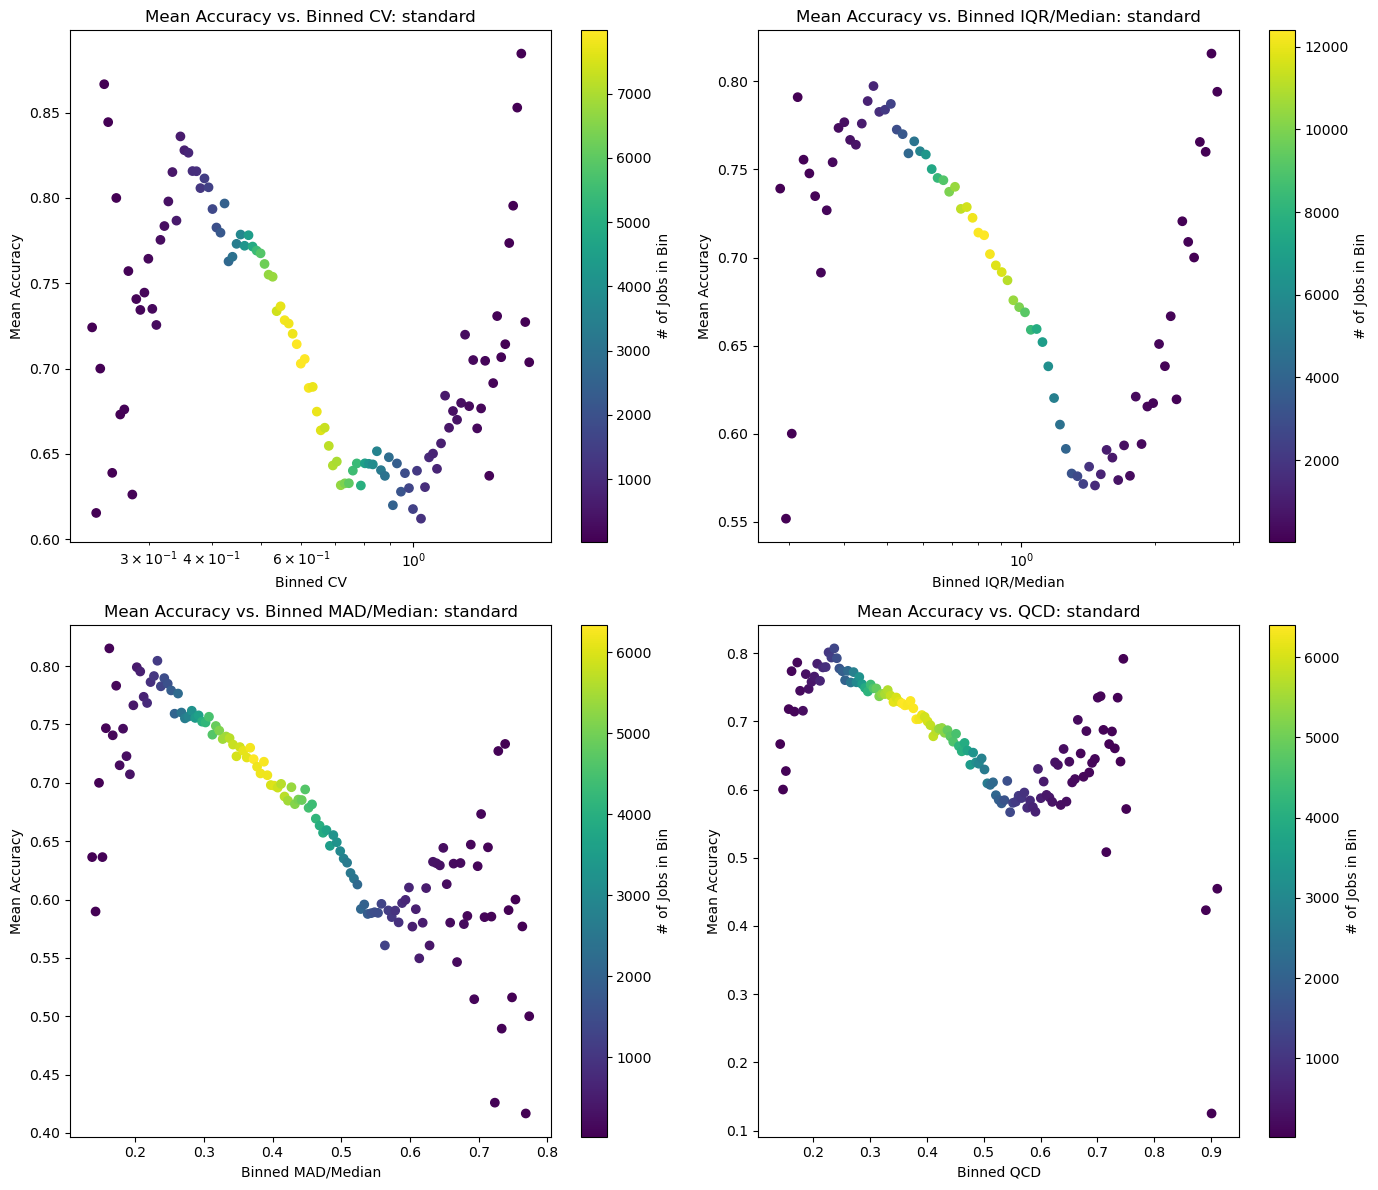




                                            short-stdby                                             


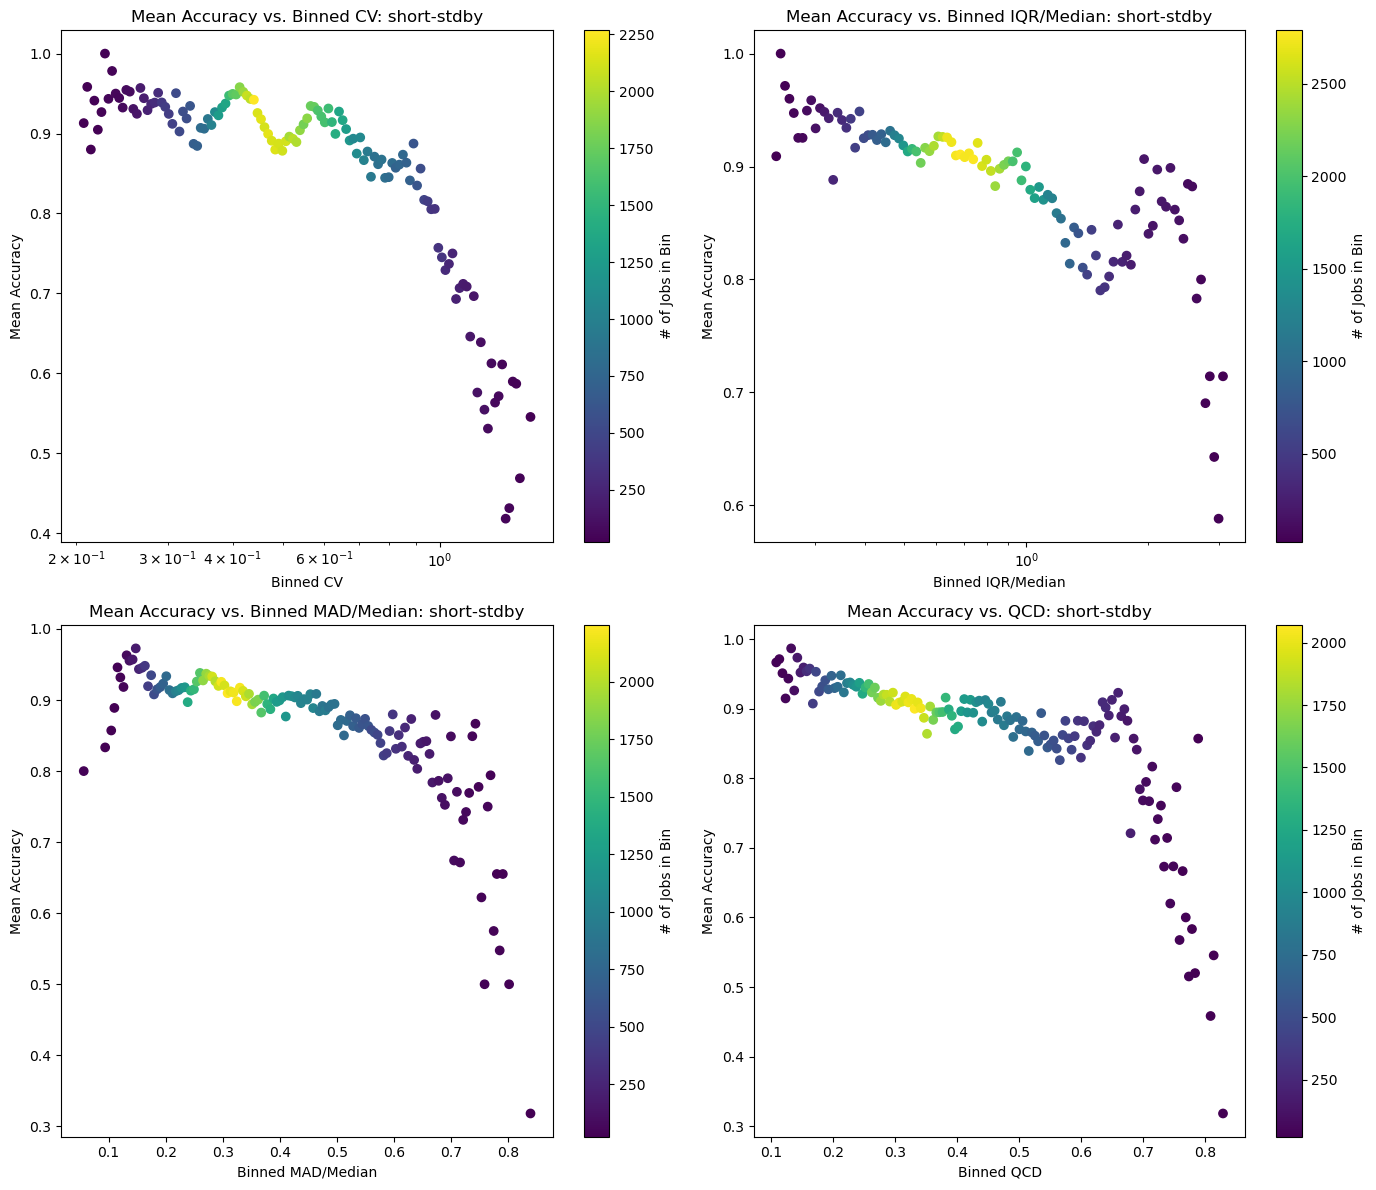




                                                gpu                                                 


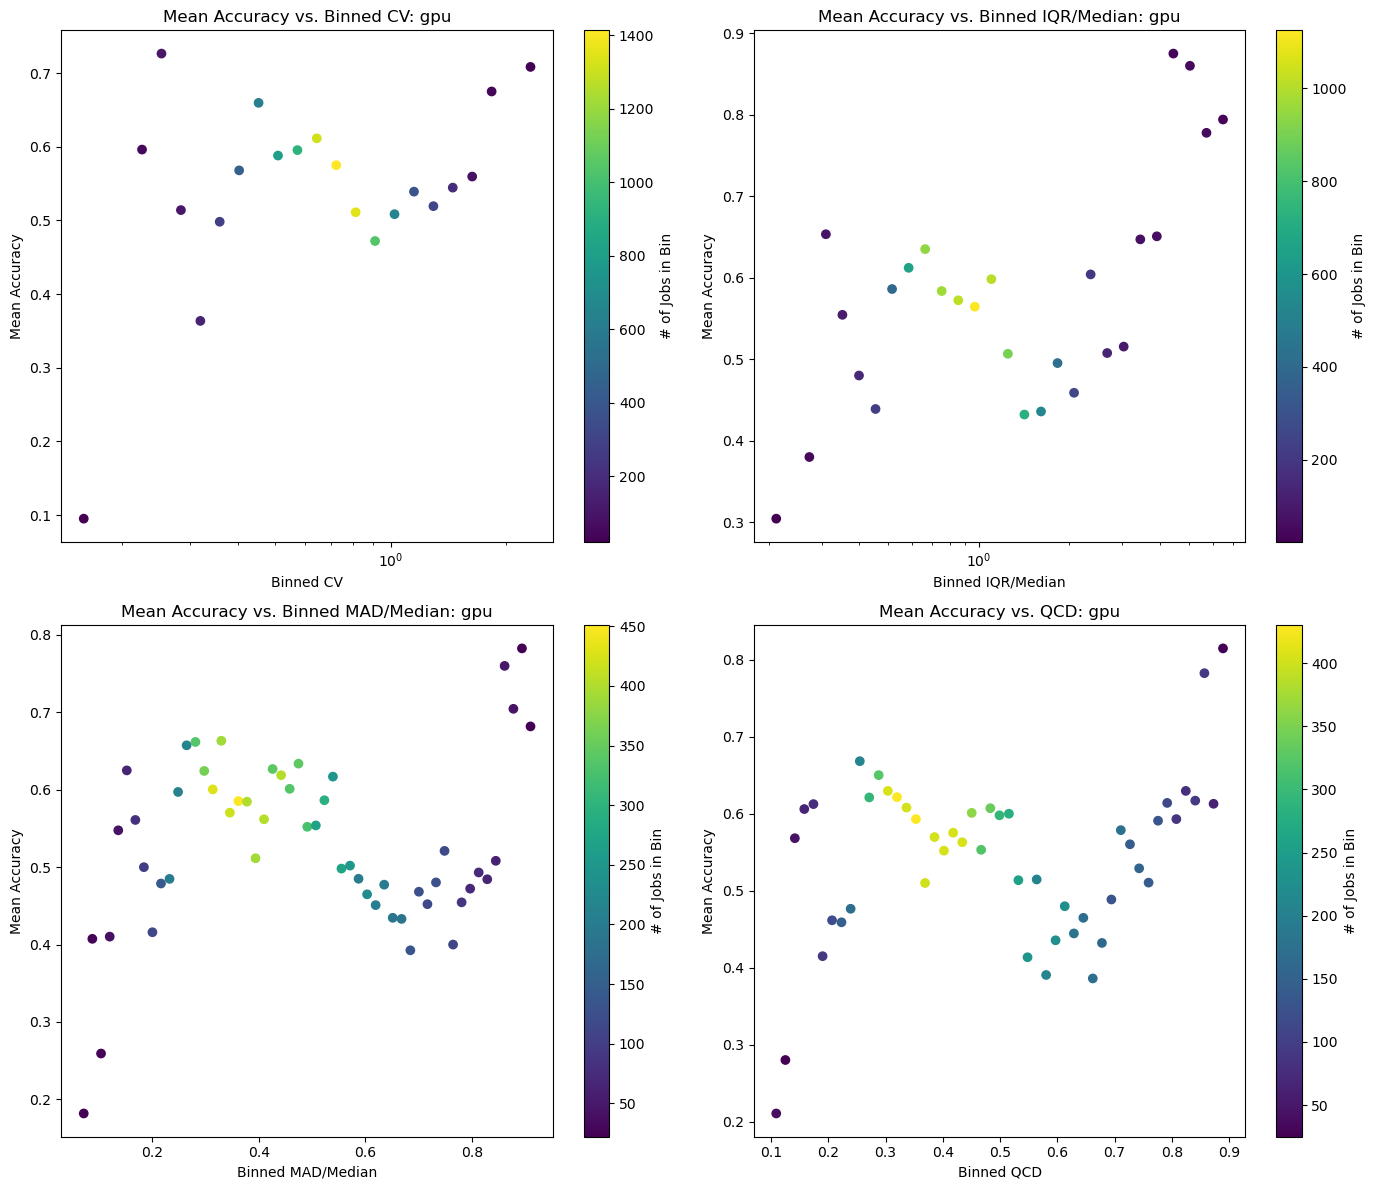




                                               debug                                                


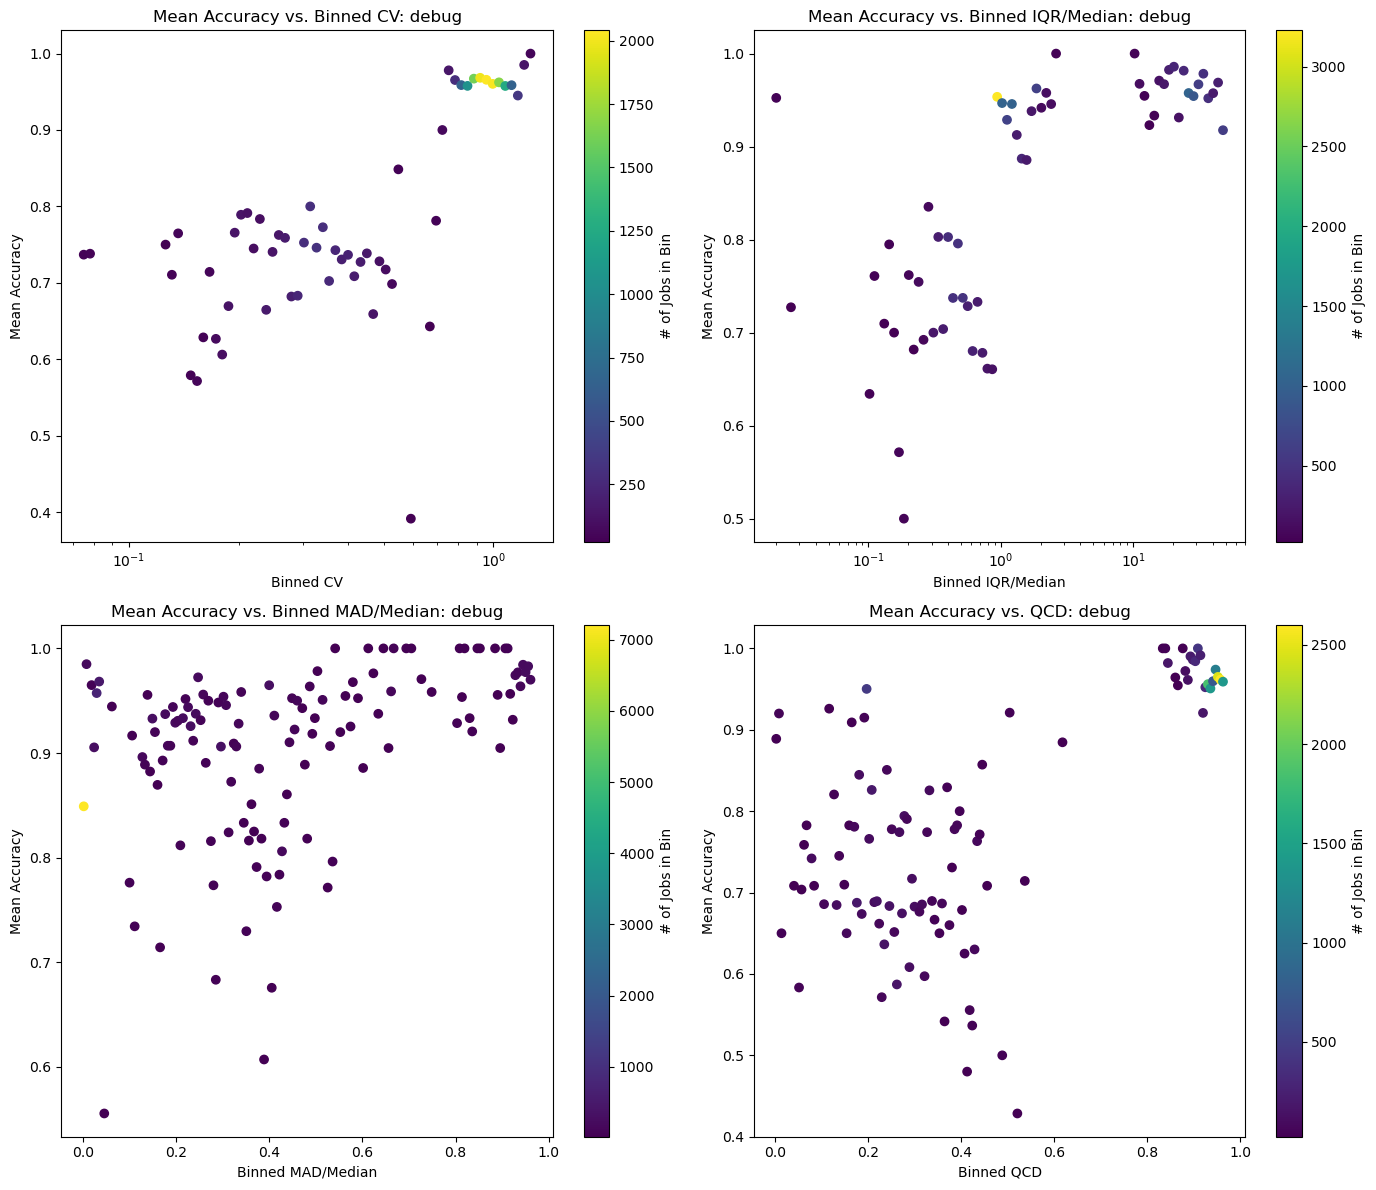




                                               short                                                


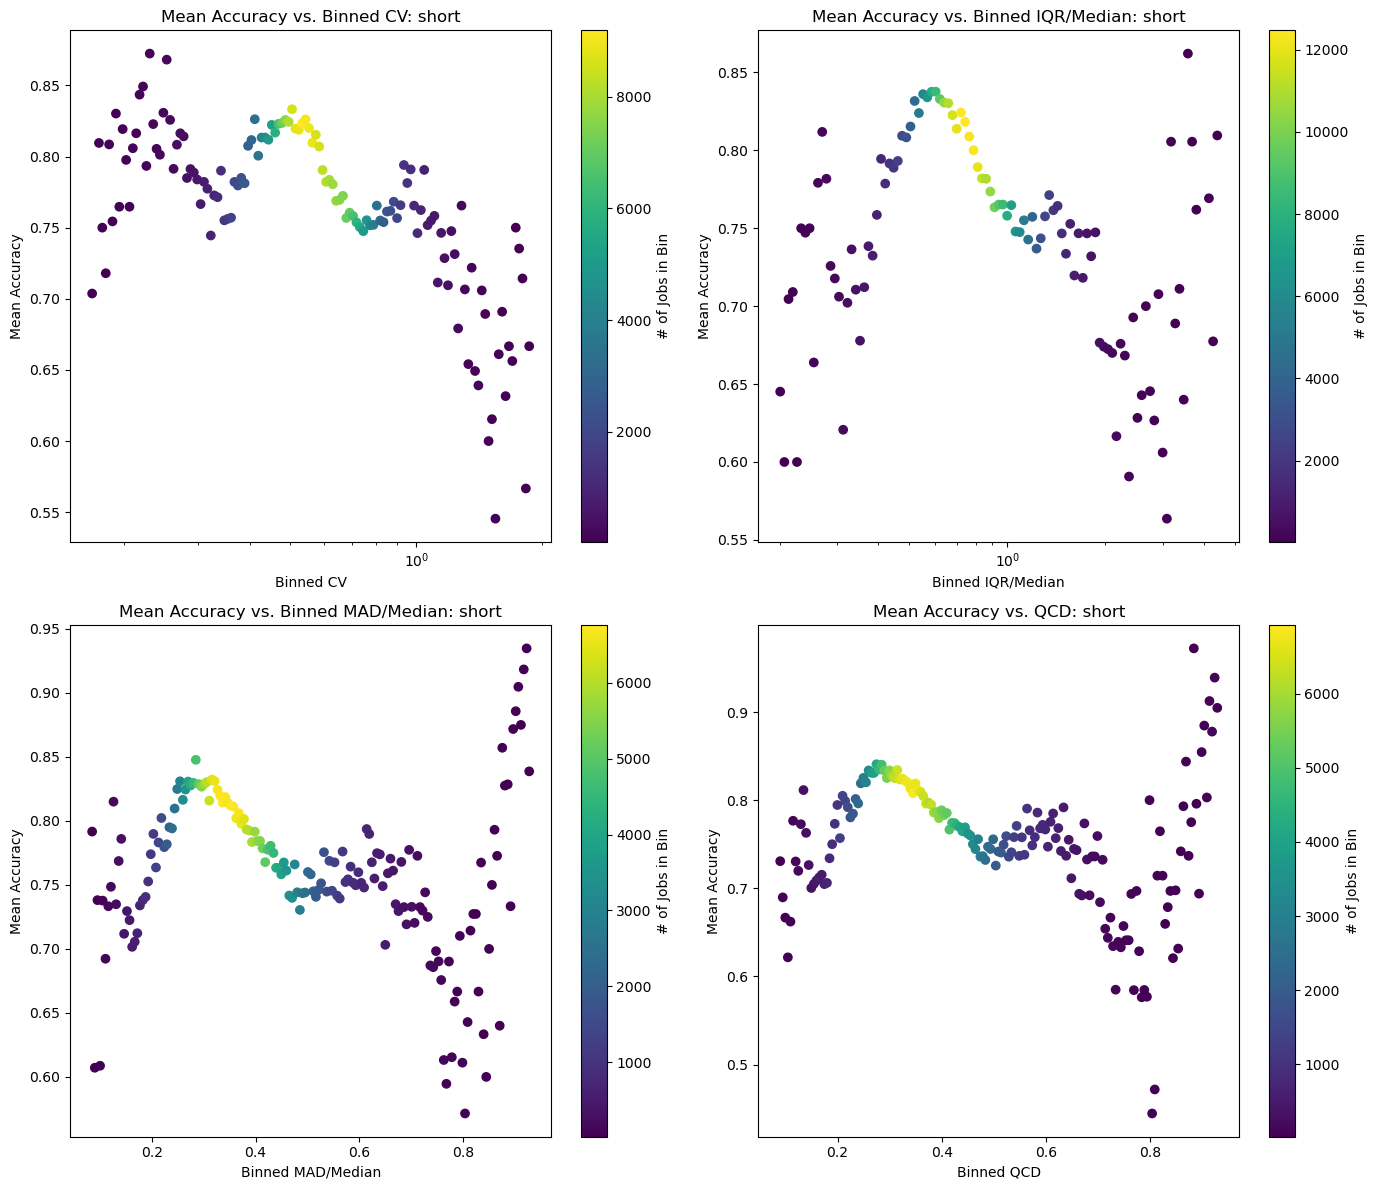




                                               bigmem                                               


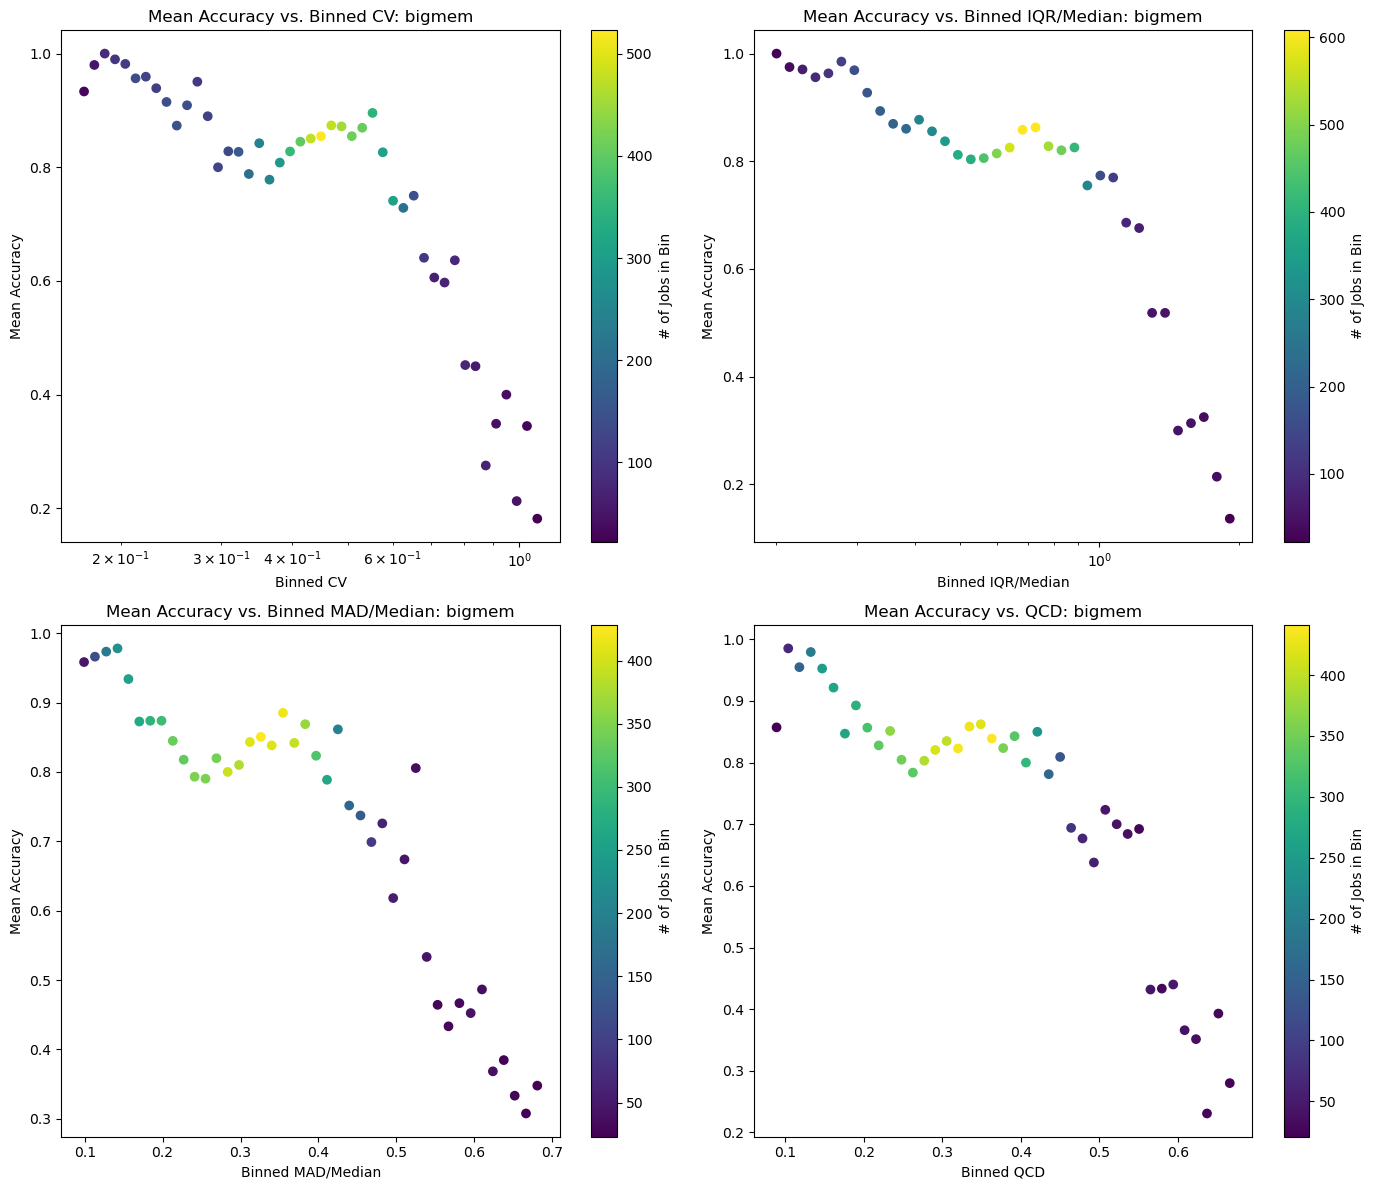




                                                off2                                                


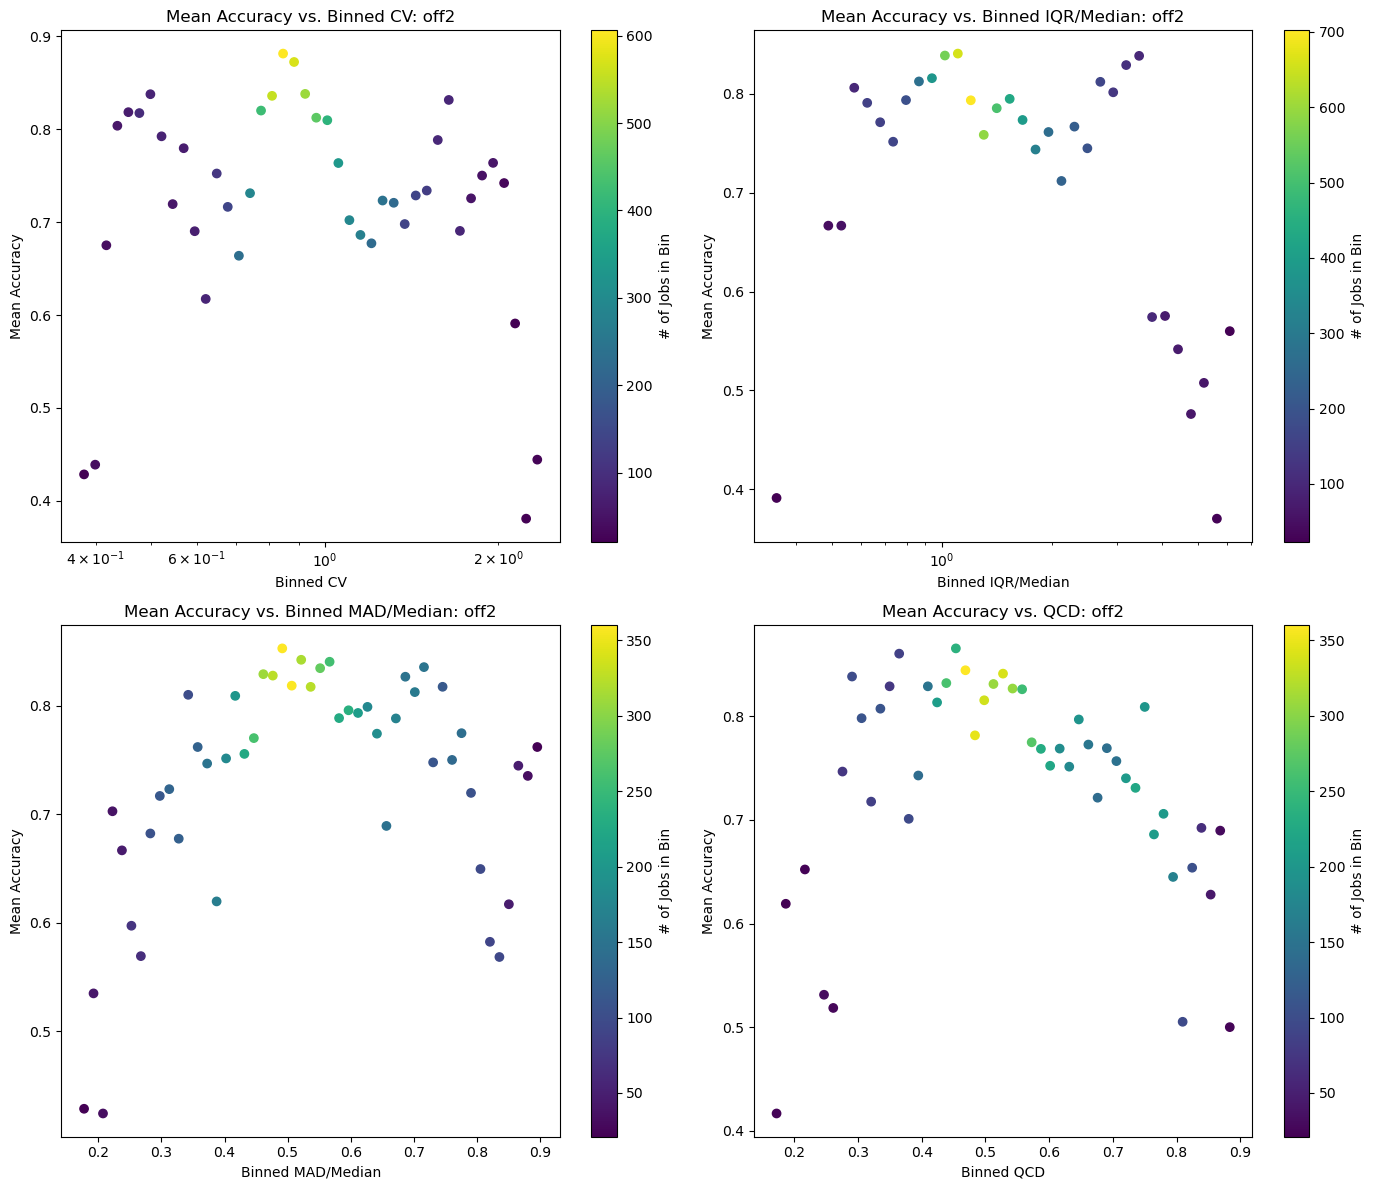




                                             long-stdby                                             


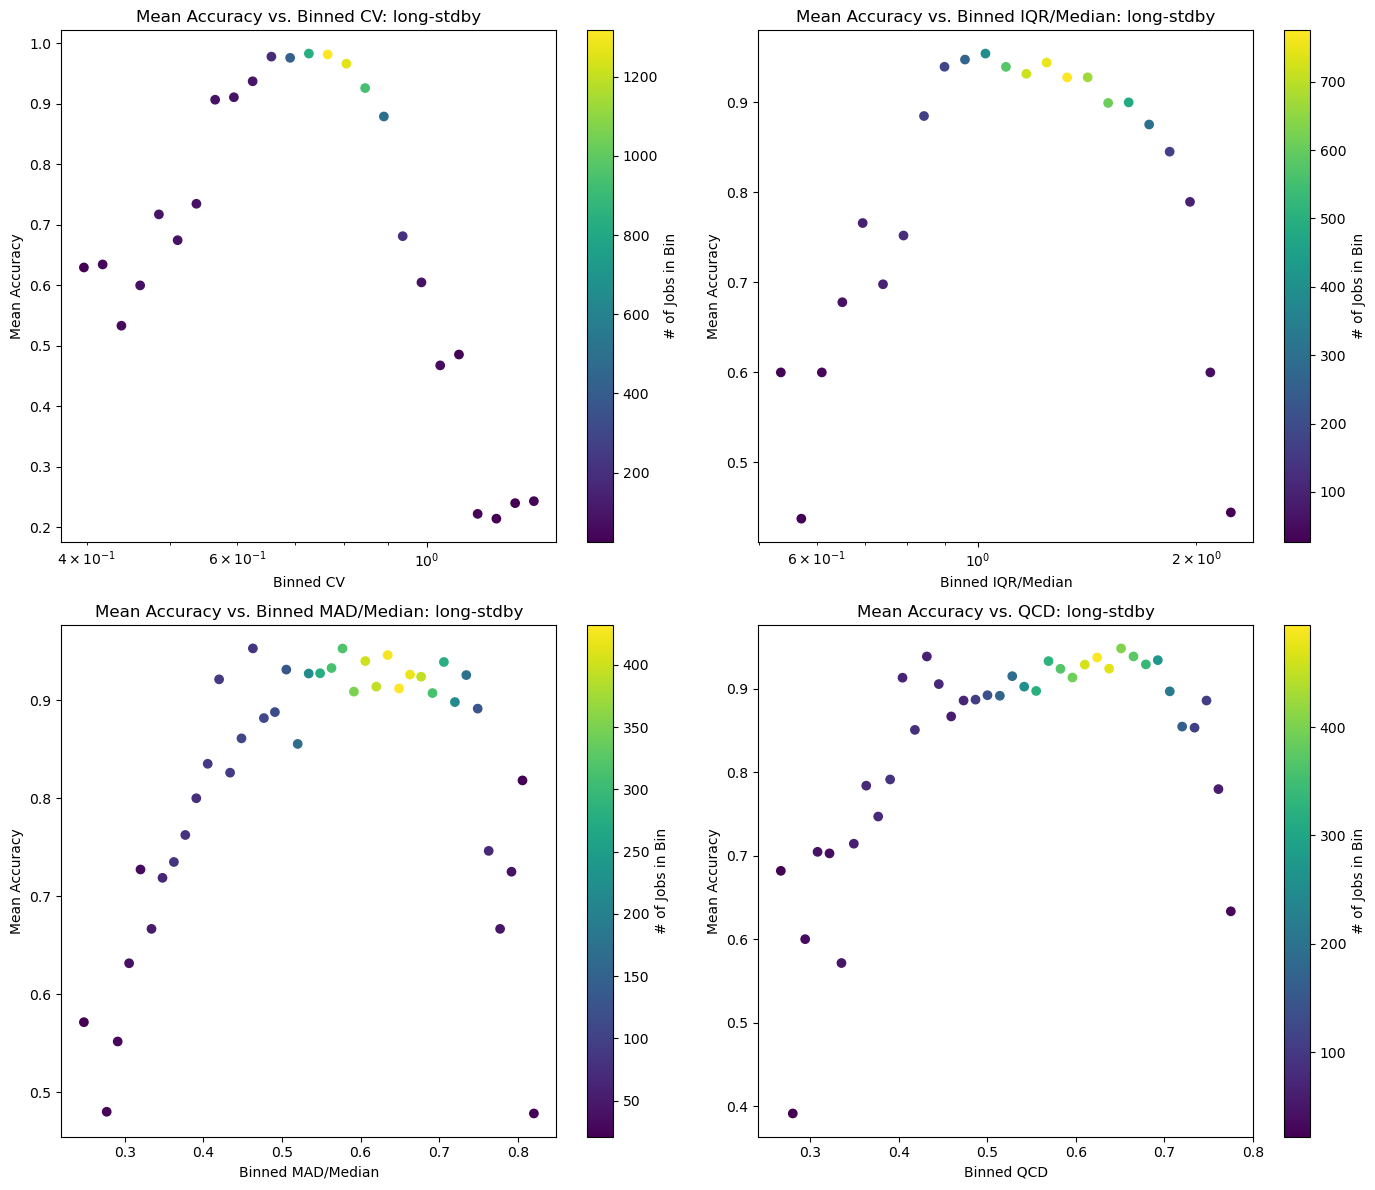




                                                long                                                


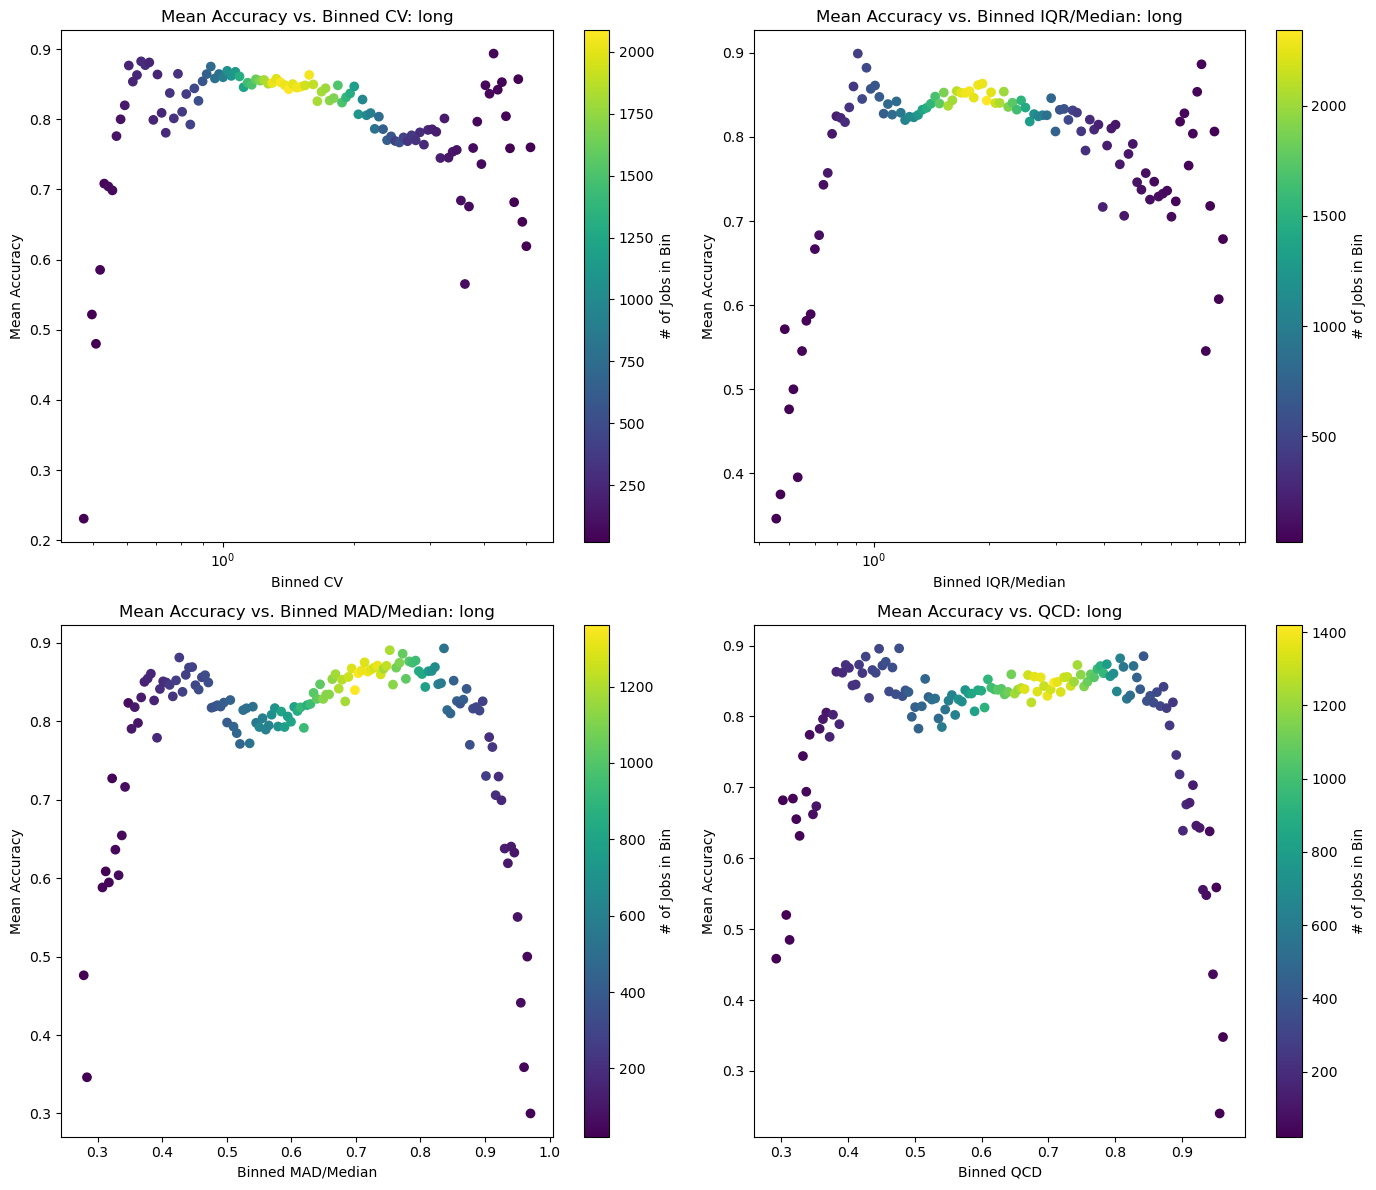




                                           standard-stdby                                           


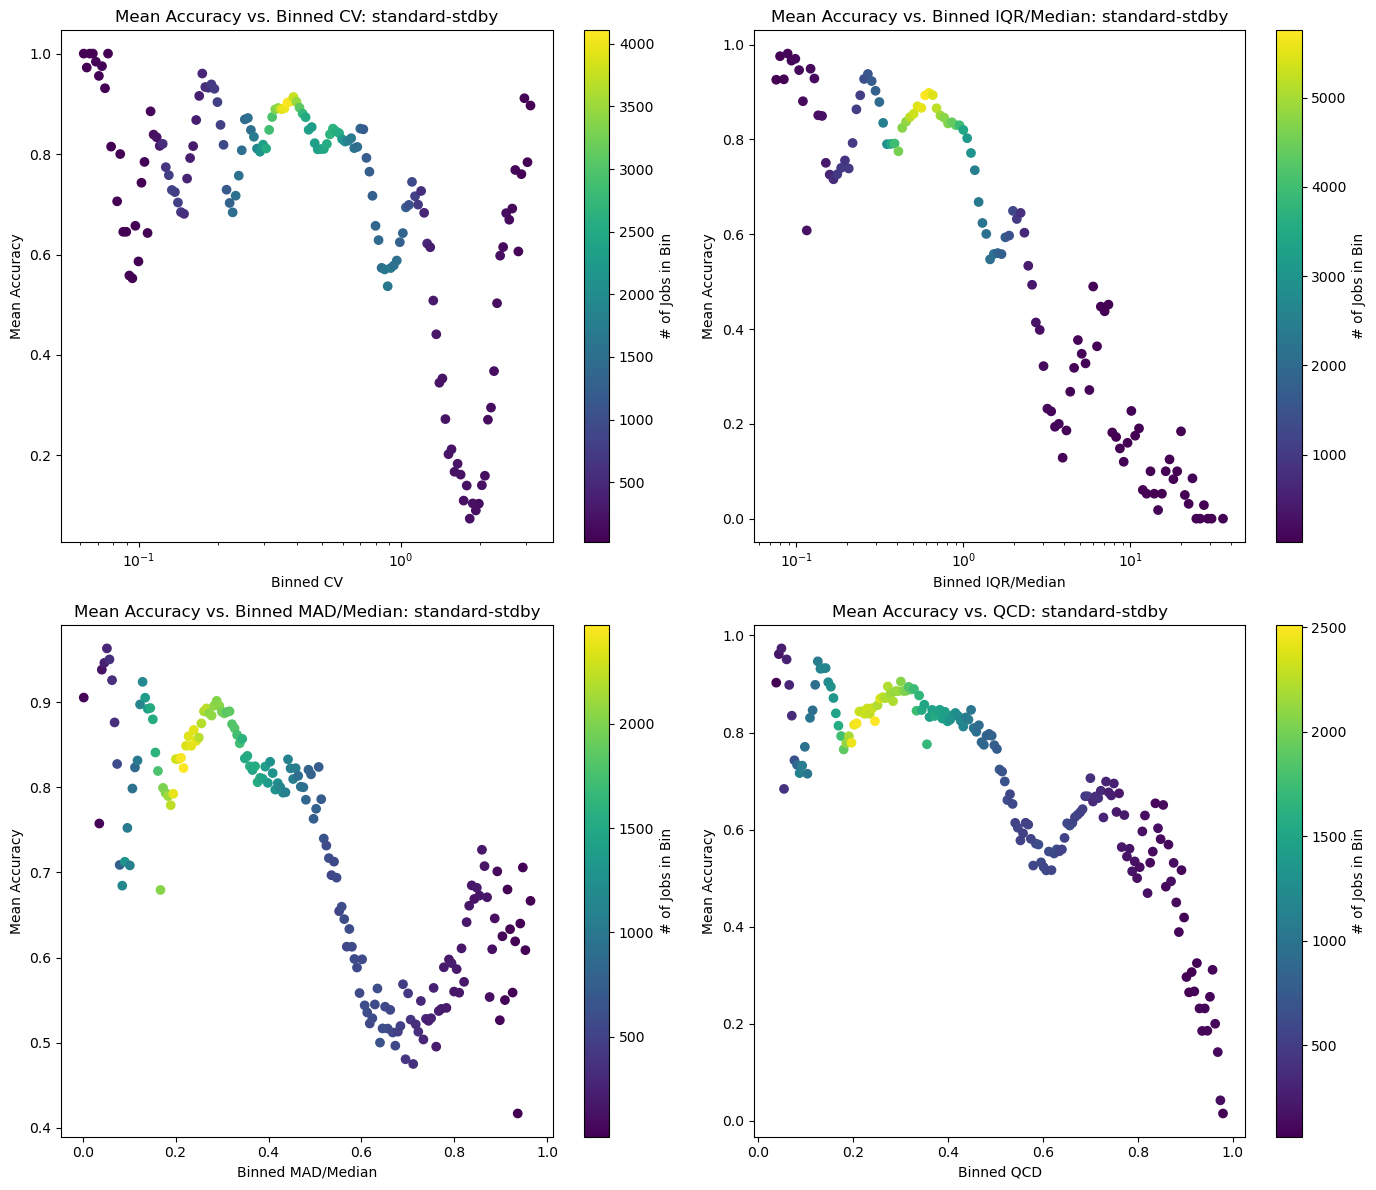




                                                off1                                                


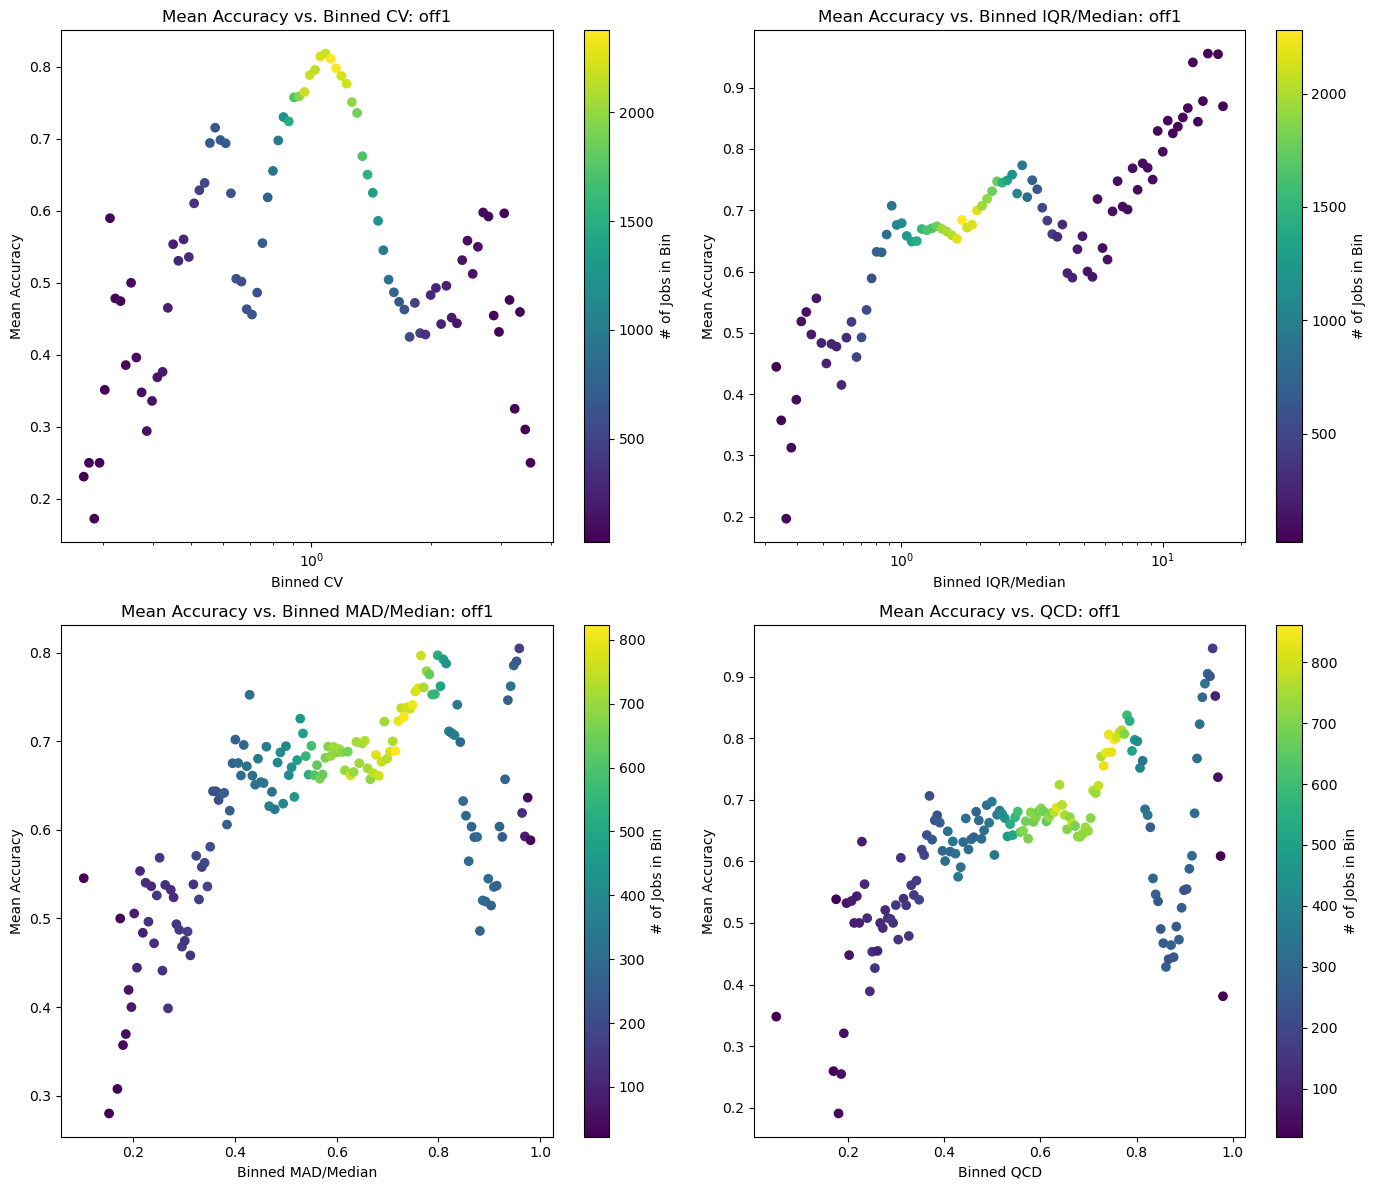




                                            debug-stdby                                             


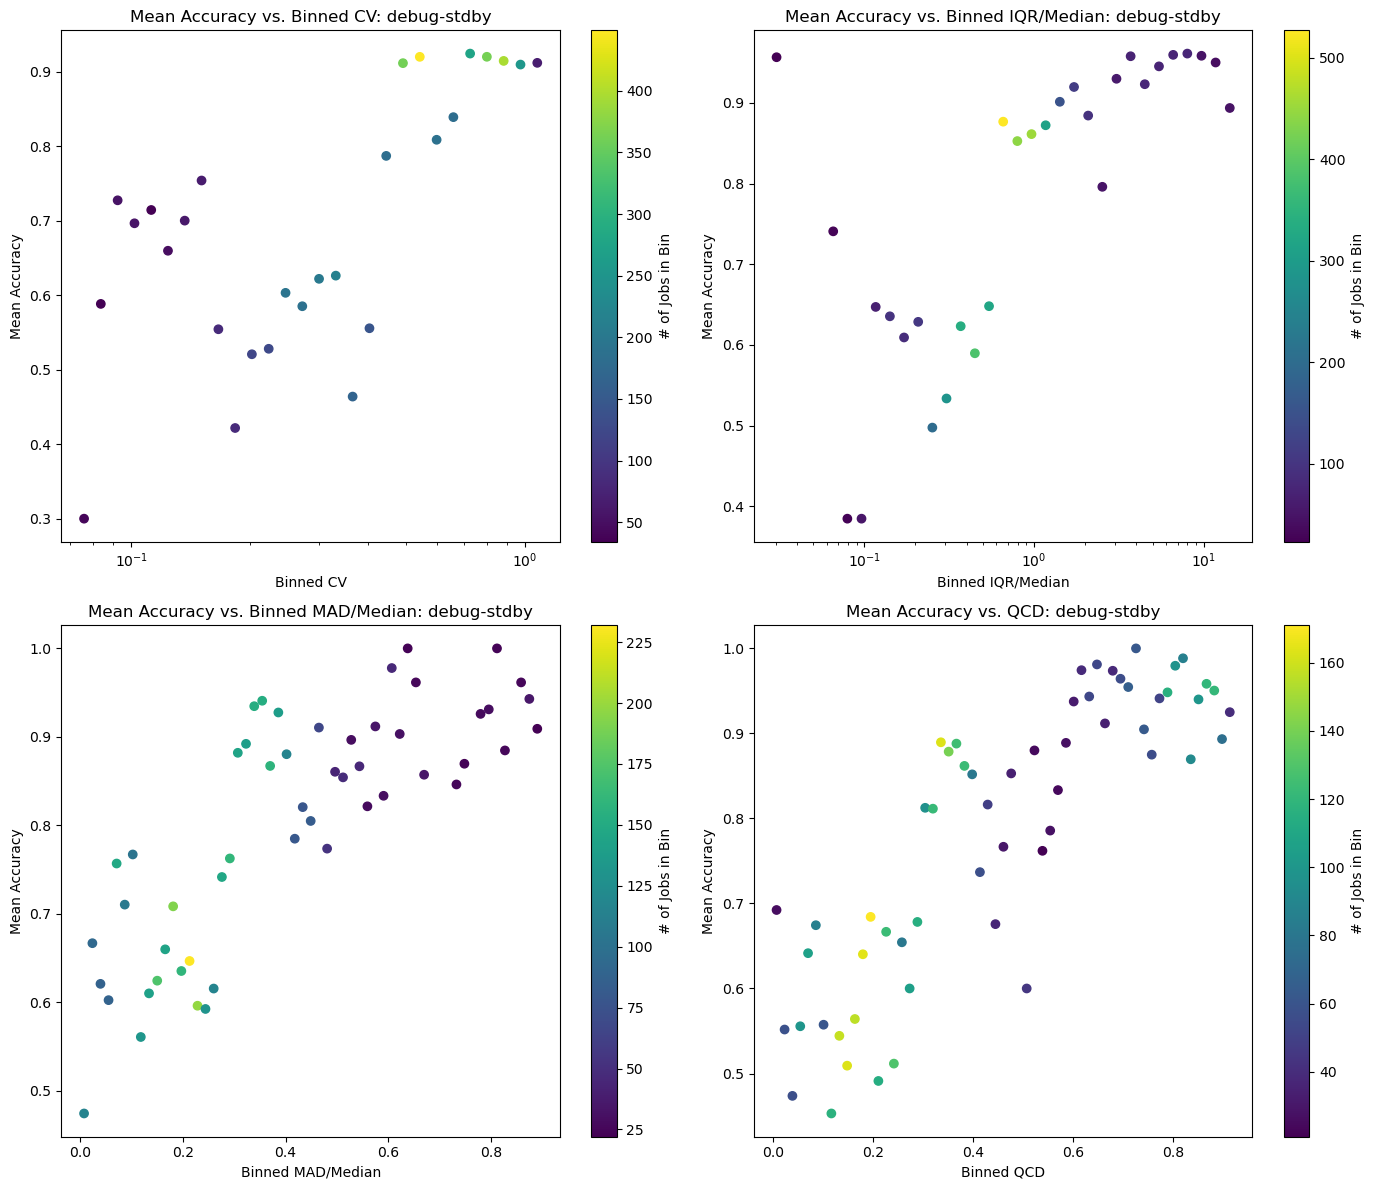




                                             gpu-stdby                                              


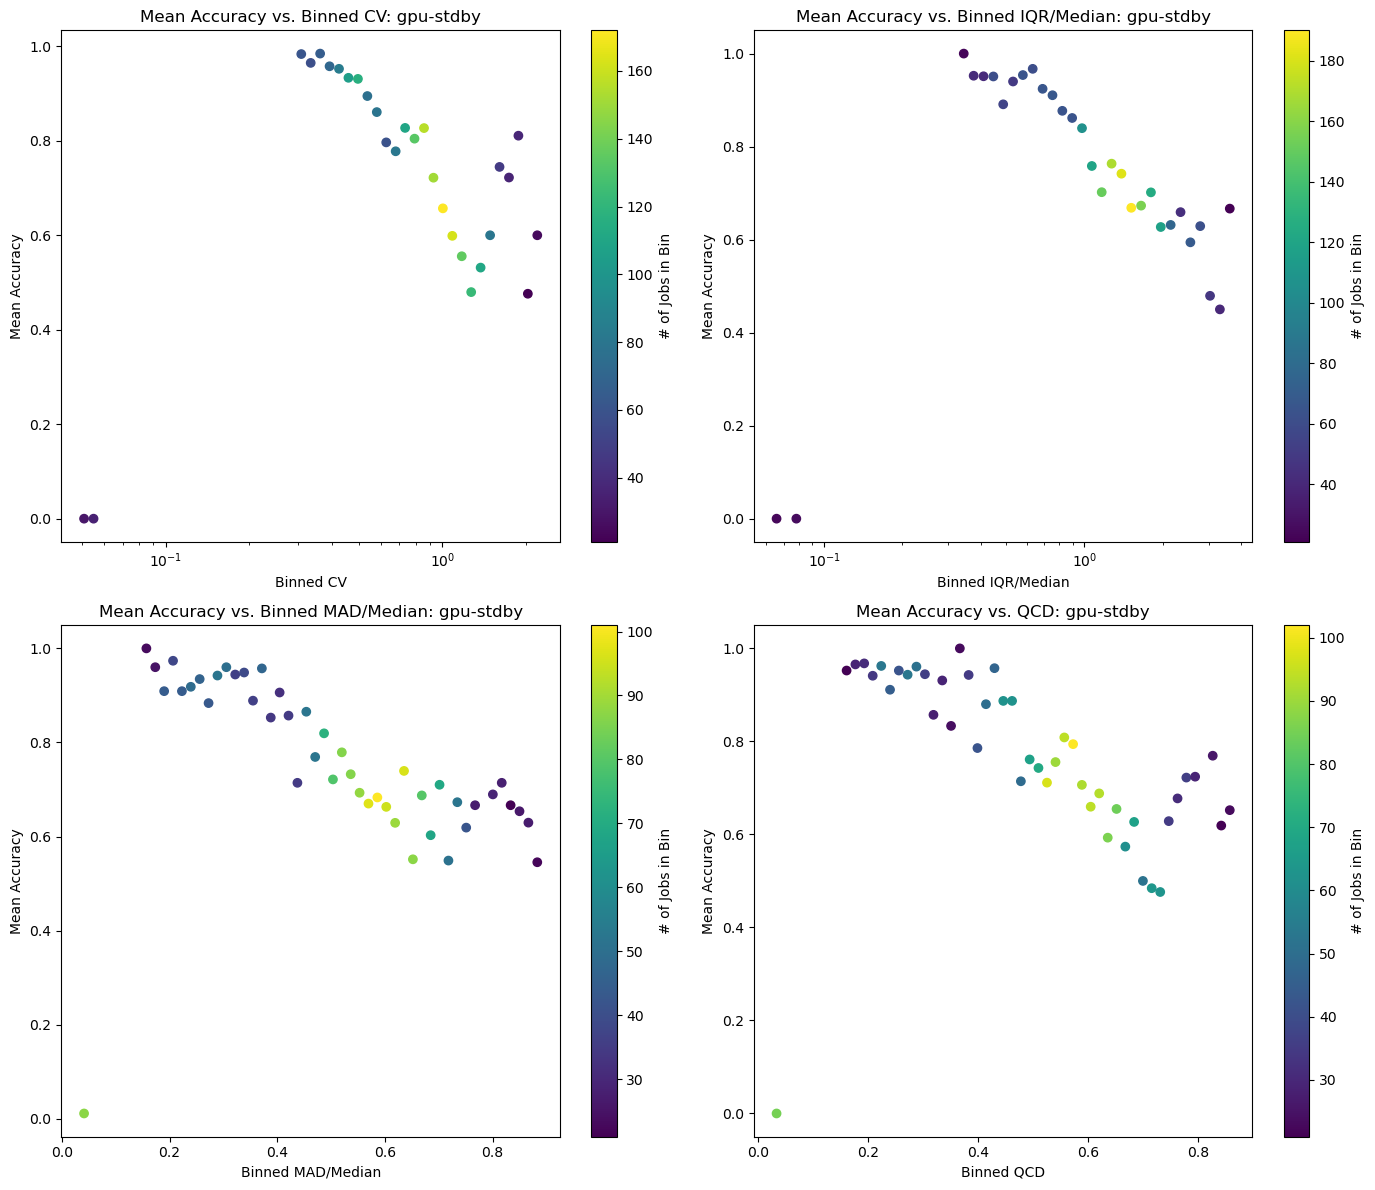

In [22]:
for partition in results_df.partition.unique():
    plot_accuracy_vs_bins(results_df[results_df.partition == partition].copy())

### Fixed Confidence Analysis

For this analysis, rather than fixing an arbitrary factor to get upper and lower bounds, we fix the $\text{Accuracy}$ (what we call $\text{Confidence}$) at a specific value (we use 0.7) and determine the necessary factor ($F$) required to achieve that confidence level. The basic idea here is, higher $F$ provides a wider range between $LB$ and $UB$, so more jobs will have their $r_a$ between the bounds. 

In other words, we seek the lowest $F$ such that 70% of jobs in the bin have:

$\frac{r_a}{F} < r_a < r_a*F$

In [35]:
def get_factor_for_fixed_confidence(df, partition, target_accuracy, plot=False):
    partition_df = df[df.partition == partition].copy()
    
    if len(partition_df) < 120: 
        n_bins = 10
    else:
        n_bins = 120

    partition_df['mad_med_bins'] = pd.cut(partition_df['mad_med'], bins=n_bins)

    left_bound = np.percentile(partition_df['mad_med'], 5)
    right_bound = np.percentile(partition_df['mad_med'], 95)

    factor_results = {}
    mad_med_counts = list()
    for bin, grp in partition_df.groupby('mad_med_bins'):
        if len(grp) < 50:
            continue
        filtered_data = grp.copy()
        factor = 1
        achieved_target = False
    
        while factor < 100 and not achieved_target:
            filtered_data['lower_bound'] = filtered_data['queue_wait_pred'] / factor
            filtered_data['upper_bound'] = filtered_data['queue_wait_pred'] * factor
    
            filtered_data['hit'] = filtered_data['queue_wait'].between(filtered_data['lower_bound'], filtered_data['upper_bound'])

            accuracy = filtered_data['hit'].mean()
                
            if accuracy >= target_accuracy:
                achieved_target = True
                factor_results[bin] = factor
                mad_med_counts.append(len(grp))
            else:
                factor += .01
        #if not achieved_target:
        #    factor_results[bin] = 1
    if plot and len(factor_results) > 0:
        
        fig, ax = plt.subplots(1,1,figsize=(9.16, 3.5), dpi=150)
        mad_med_mids = [bin.mid for bin in factor_results]
        ax.fill_between(mad_med_mids, max(factor_results.values()) + 1, 
                        where=(mad_med_mids >= left_bound) &  (mad_med_mids <= right_bound), 
                        color='#add8e6', alpha=0.2, label='90% Interpercentile Range')
        scatter_mad_med = ax.scatter(mad_med_mids, factor_results.values(), c=mad_med_counts)
        ax.set_xlabel(r'Binned $\frac{MAD}{Median}$')
        ax.set_ylabel('Multiplicative Factor')
        ax.set_title(f'Multiplicative Factor for Fixed Confidence (70%): {partition.title()} Partition')
        plt.colorbar(scatter_mad_med, ax=ax, label='# of Jobs in Bin')
        y_min = min([v for k, v in factor_results.items() if k.mid >= left_bound and k.mid <= right_bound]) - 1.2
        y_max = max([v for k, v in factor_results.items() if k.mid >= left_bound and k.mid <= right_bound]) + 1.2
        x_min = left_bound/1.2
        x_max = right_bound*1.2
        #ax.set_xlim([x_min, x_max])
        plt.ylim([y_min, y_max])
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
    
    return factor_results

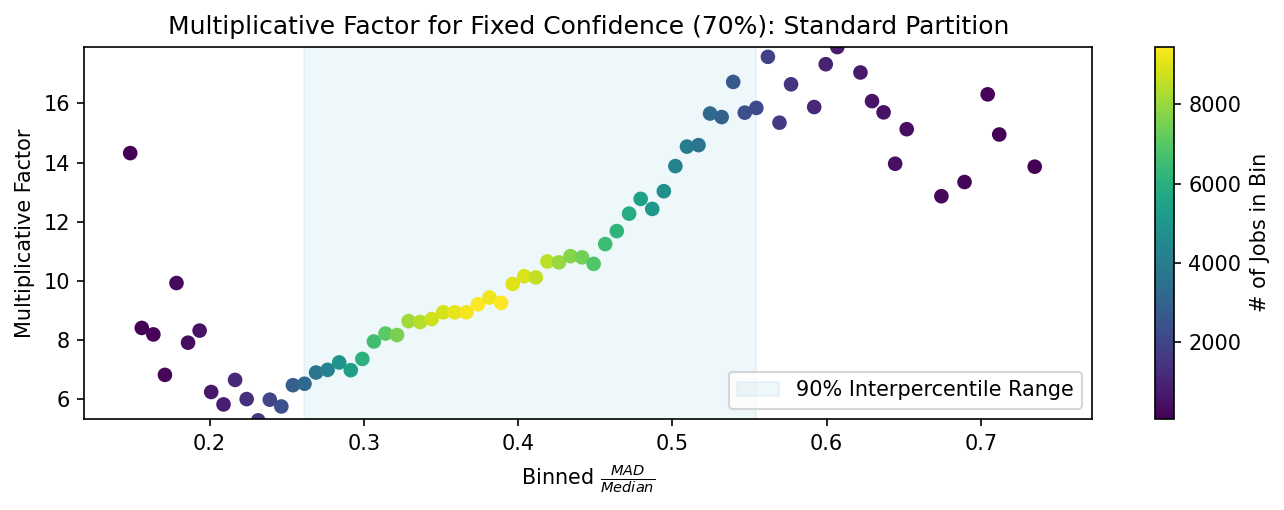

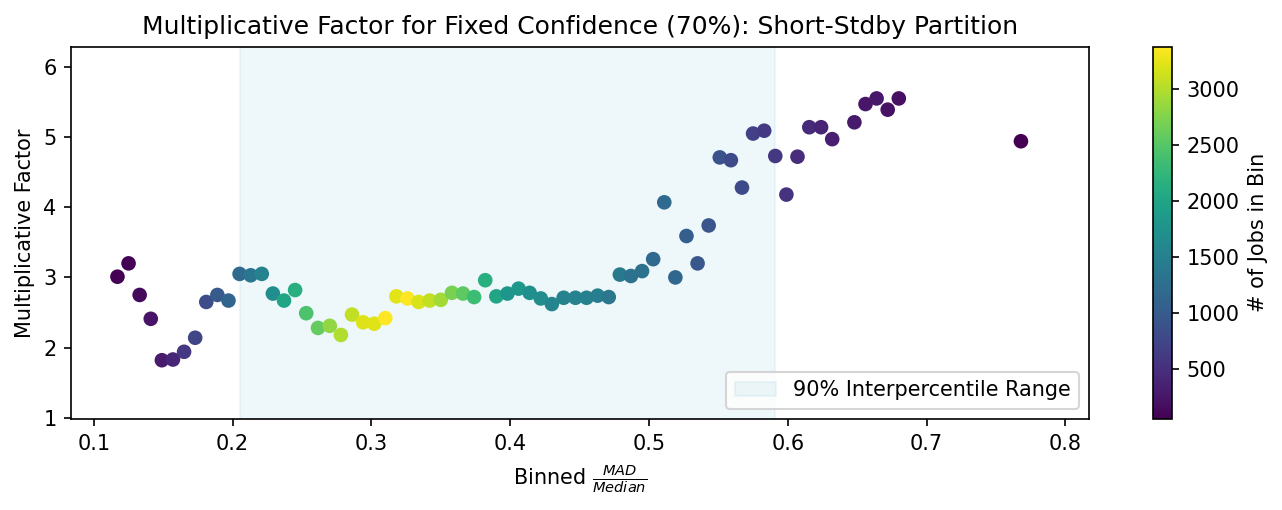

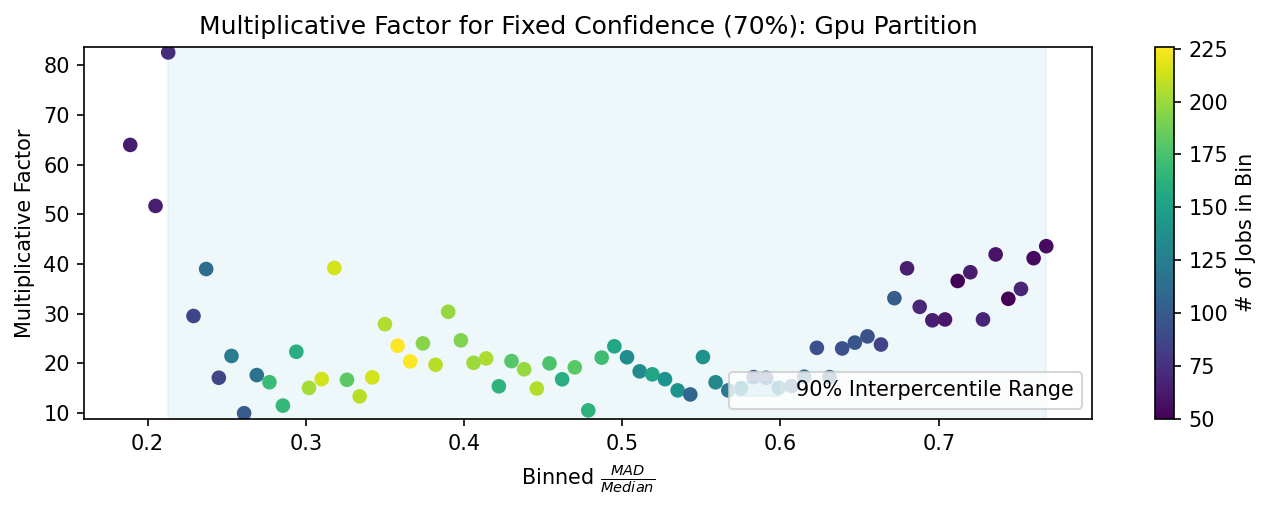

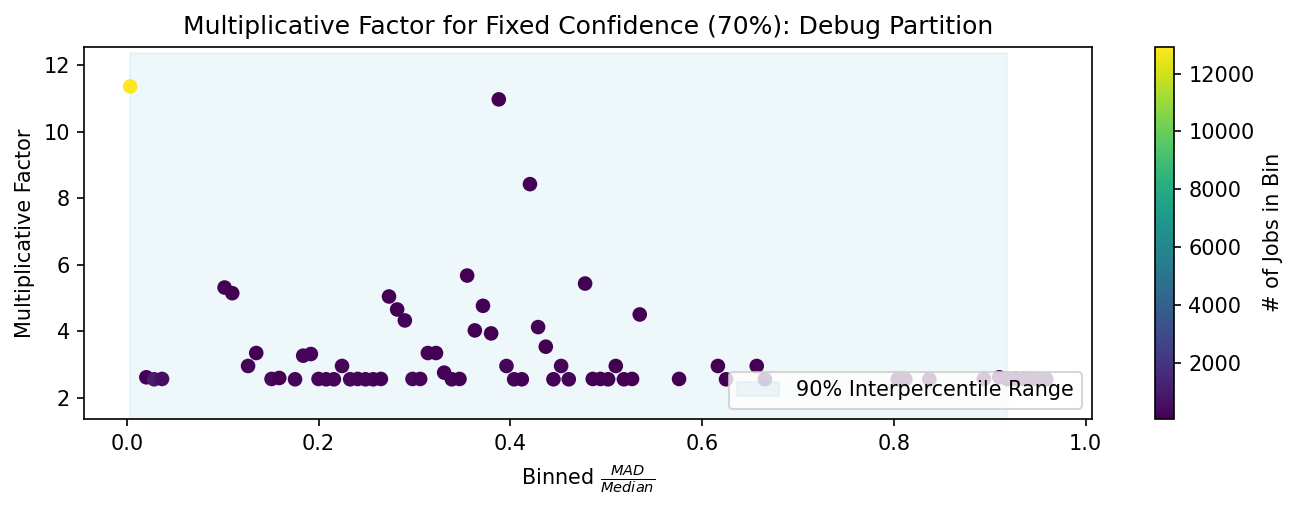

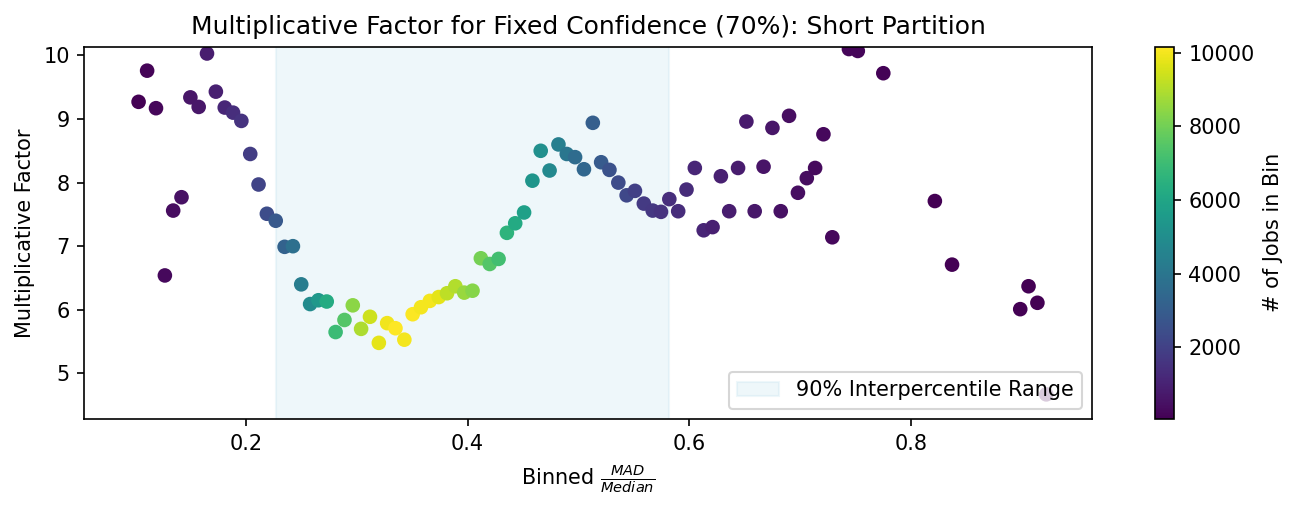

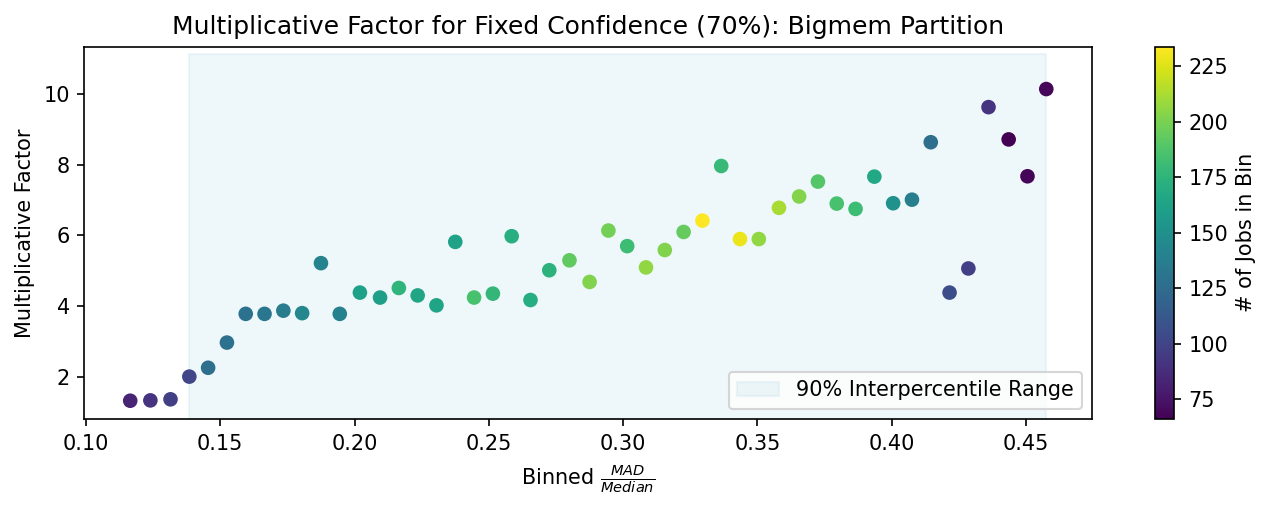

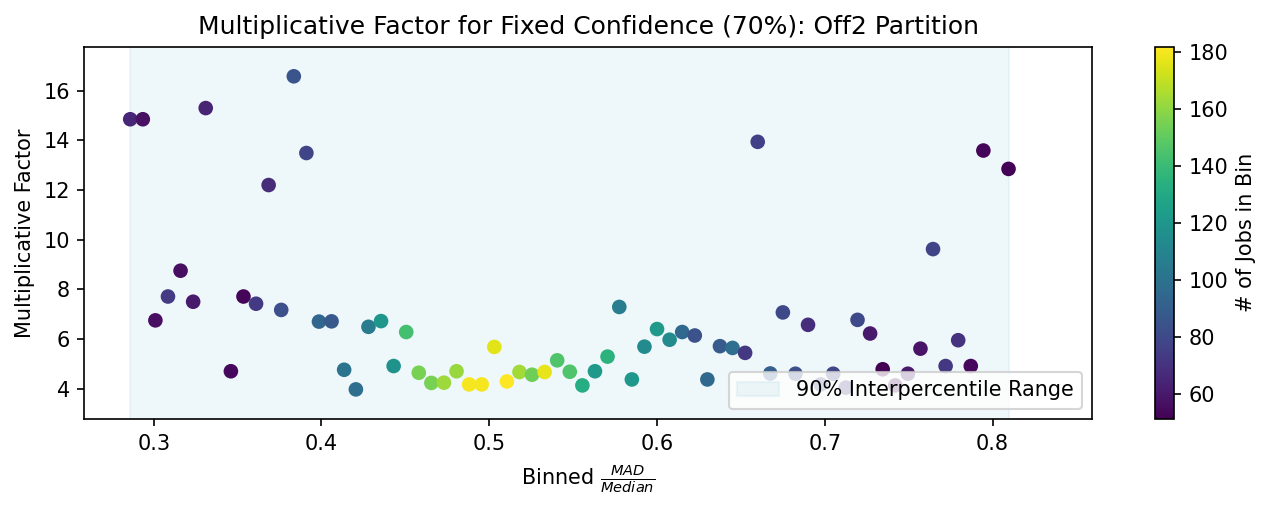

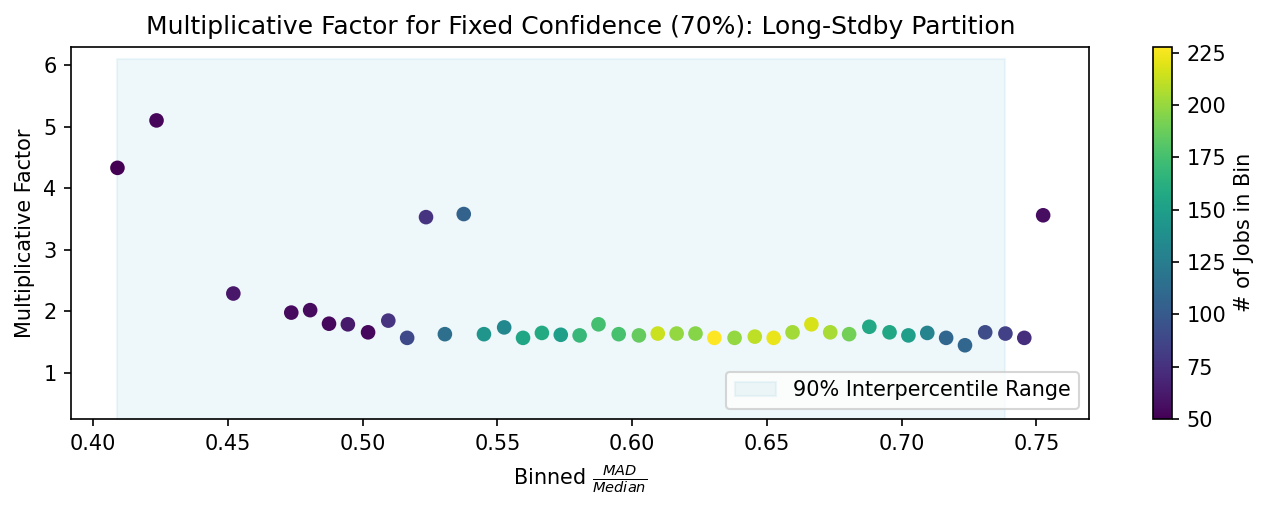

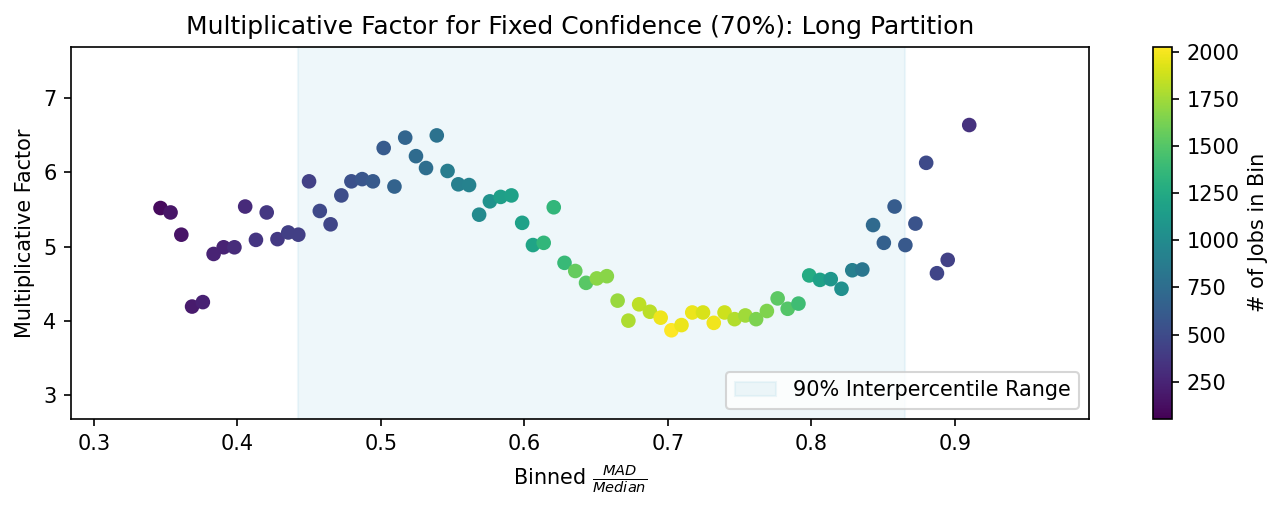

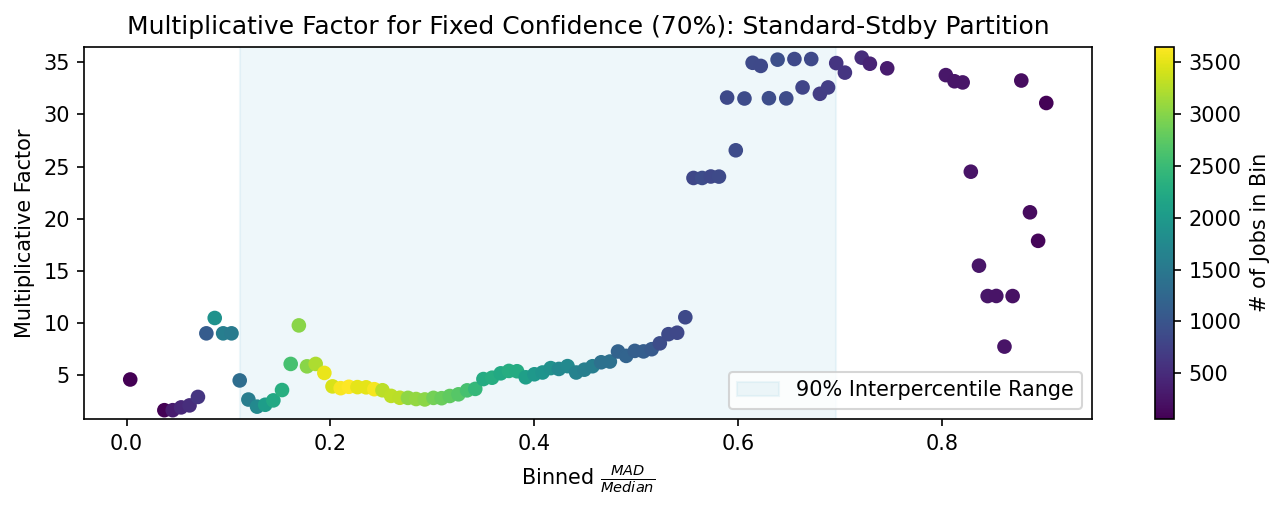

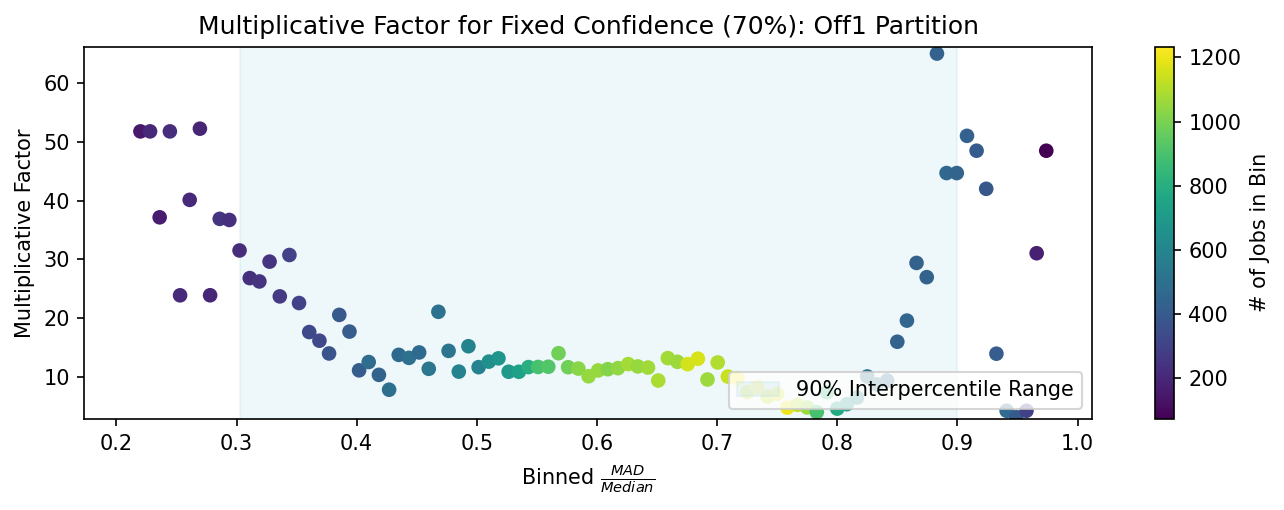

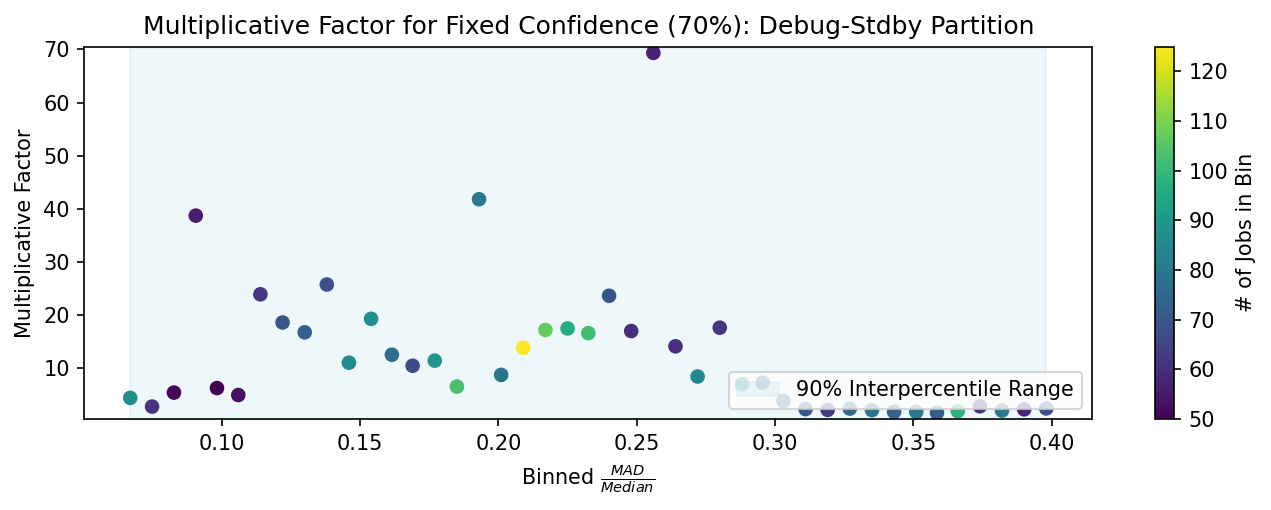

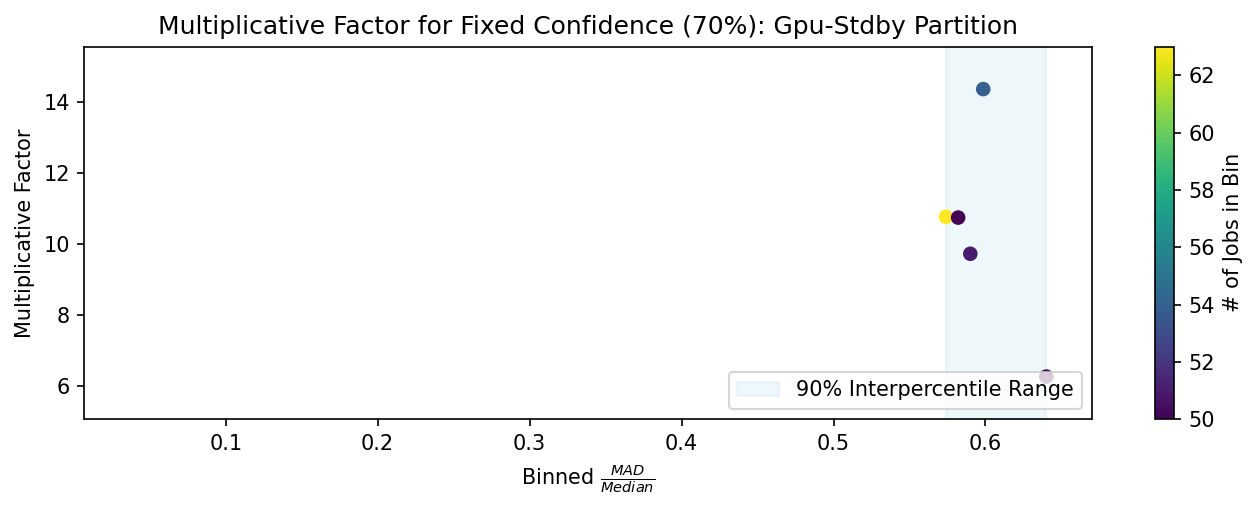

In [36]:
factor_results = dict()
target_accuracy = .7
for partition in results_df.partition.unique():
    factor_results[partition] = get_factor_for_fixed_confidence(results_df, partition, target_accuracy, plot=True)